# Unsupervised Segmentation of 3D room dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import torch
import genus as gn
import numpy
from genus.util_data import ImageFolderWithIndex, DataloaderWithLoad
from genus.util import linear_interpolation, append_to_dict, ckpt2file, load_json_as_dict
from genus.util_vis import show_batch
from genus.model import CompositionalVae, instantiate_optimizer, instantiate_scheduler, process_one_epoch
from functools import partial

### Read the config file 

In [5]:
root_data_dir = "/Users/ldalessi/REPOS/genus/new_dataset/OBJ3D_SMALL"
config_file_3droom_small = "/Users/ldalessi/REPOS/genus/notebooks/config_3d_room_small.json"
config = load_json_as_dict(config_file_3droom_small)

### Create the dataset

In [15]:
from torchvision import transforms

def idx_to_nobject(class_to_idx: dict, x: int):
    idx_to_class = {v: int(k.split("_")[-1]) for k, v in class_to_idx.items()}
    return idx_to_class[x]

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = ImageFolderWithIndex(root_data_dir+"/train", transform=transform)
test_dataset = ImageFolderWithIndex(root_data_dir+"/test", transform=transform) 

# With this transformation the labels correspond to the number of objects
test_dataset.target_transform = partial(idx_to_nobject, test_dataset.class_to_idx)
train_dataset.target_transform = partial(idx_to_nobject, train_dataset.class_to_idx)

batch_size = 1 #config["simulation"]["batch_size"]
train_loader = DataloaderWithLoad(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataloaderWithLoad(test_dataset, batch_size=batch_size, shuffle=True)

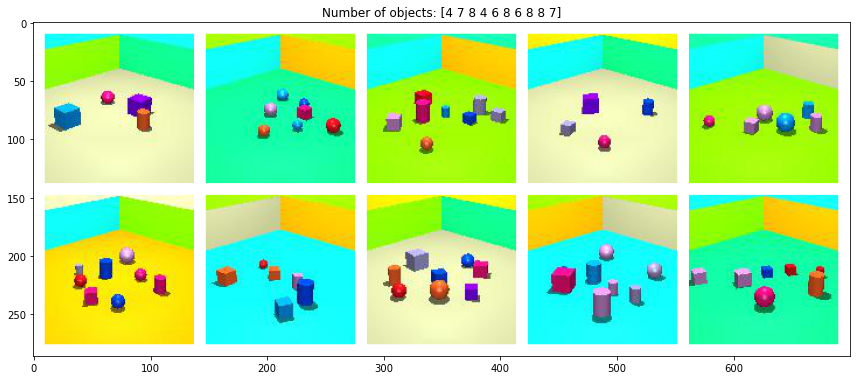

In [16]:
images, labels, index = test_loader.load(batch_size=10)
show_batch(images, title="Number of objects: "+str(labels.numpy()), n_col=5, figsize=(12,12))

### Instantiate the model, optimizer and scheduler

In [17]:
vae = CompositionalVae(config)
optimizer = instantiate_optimizer(model=vae, config_optimizer=config["optimizer"])

if config["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999

elif config["simulation"]["type"] == "resume":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', -1)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999

elif config["simulation"]["type"] == "pretrained":

    if torch.cuda.is_available():
        ckpt = file2ckpt(path="ckpt.pt", device=None)
    else:
        ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if config["scheduler"]["is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, config_scheduler=config["scheduler"])
else:
    scheduler = None

### Training loop

In [18]:
TEST_FREQUENCY = config["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = config["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = config["simulation"]["MAX_EPOCHS"]

for epoch in range(NUM_EPOCHS+1):
    
    vae.annealing_factor = linear_interpolation(epoch,
                                                values=(1.0, 0.0),
                                                times=config["loss"]["annealing_times"])
    
    vae.train()
    train_metrics = process_one_epoch(model=vae,
                                      dataloader=train_loader,
                                      optimizer=optimizer,
                                      scheduler=scheduler,
                                      iom_threshold=config["architecture"]["nms_threshold_train"],
                                      verbose=(epoch == 0))
    
    with torch.no_grad():
        print("Train " + train_metrics.pretty_print(epoch))
        history_dict = append_to_dict(source=train_metrics,
                                      destination=history_dict,
                                      prefix_exclude="wrong_examples",
                                      prefix_to_add="train_")
        
        if (epoch % TEST_FREQUENCY) == 0:
            vae.eval()
            test_metrics = process_one_epoch(model=vae,
                                             dataloader=test_loader,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             iom_threshold=config["architecture"]["nms_threshold_test"],
                                             verbose=(epoch == 0))
            print("Test  "+test_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=test_metrics,
                                          destination=history_dict,
                                          prefix_exclude="wrong_examples",
                                          prefix_to_add="test_")
            
        if (epoch % CHECKPOINT_FREQUENCY == 0) and (epoch >= 20):
            ckpt = vae.create_ckpt(optimizer=optimizer,
                                   epoch=epoch,
                                   history_dict=history_dict)
            ckpt2file(ckpt=ckpt, path="last_ckpt_"+str(epoch))

i =   0 train_loss=11978.16992
i =   1 train_loss=12548.09863
i =   2 train_loss=13665.17383
i =   3 train_loss=9236.71973
i =   4 train_loss=6717.49316
i =   5 train_loss=7796.30176
i =   6 train_loss=9300.47754
i =   7 train_loss=5615.17383
i =   8 train_loss=19104.21875
i =   9 train_loss=8553.25098
i =  10 train_loss=9344.39160
i =  11 train_loss=6487.30664
i =  12 train_loss=11722.69434
i =  13 train_loss=11795.53711
i =  14 train_loss=7093.24219
i =  15 train_loss=11521.92676
i =  16 train_loss=7062.25000
i =  17 train_loss=5364.16748
i =  18 train_loss=10558.08984
i =  19 train_loss=10141.83008
i =  20 train_loss=9348.98242
i =  21 train_loss=3794.79492
i =  22 train_loss=9839.10352
i =  23 train_loss=5149.18604
i =  24 train_loss=8887.28516
i =  25 train_loss=4409.06152
i =  26 train_loss=9560.48828
i =  27 train_loss=8816.34570
i =  28 train_loss=7735.48730
i =  29 train_loss=6213.79980
i =  30 train_loss=4679.46582
i =  31 train_loss=3774.84253
i =  32 train_loss=3573.91650
i

KeyboardInterrupt: 

### Visualize the results

In [ ]:
ref_image = 

In [ ]:
x_test = numpy.arange(0,len(history_dict["test_accuracy"])*CHECKPOINT_FREQUENCY, CHECKPOINT_FREQUENCY)
plt.plot(x_test, history_dict["test_accuracy"])